# Bagging and ExtraTrees Classifier Wild Fire Model Evaluation

This notebooks will tune and run Bagging and Extra Trees classifier on wildfire dataset in order to make a predecction on fire intensity.


#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#optional code to ensure everyone is on the right version
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [3]:
#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

# Import all the models and libraries needed

In [2]:
%matplotlib inline

import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier


from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ClassificationReport

from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling





/Users/sandstone/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Helper function to save estimator
Saves to current working directory

In [ ]:
def save_estimator (estimator) :
          
    outpath = estimator.__class__.__name__.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)
        f.close()
        

In [ ]:
def open_estimator(filename) :
    
    infile = open(filename,'rb')
    estimator = pickle.load(infile)
    infile.close()

    print ("Unpickled file", filename)
    
    return estimator

### Read the Fire Data From Disk to Save Time.
During the feature evaluation the data was pulled from the database and stored locally
Read a random sample.

Optimal testing data is 150K - SMOTE will generate additonal data for us

In [4]:
df_fires = pd.read_csv('data/FireIntensity_Model_June12_Clean.csv').sample(50000)

print(df_fires.shape)

(50000, 26)


### Assess data in the file. 
Check data to ensure it's correct.


In [5]:
# Expanding number of columns:
pd.set_option('display.max_columns', 40)

In [ ]:
# review datagram
print (df_fires.shape)
df_fires.head(3) 

### Drop the columns not needed identified during the feature seleciton phase
Recommend Features:  'temperature', 'wind_speed','humidity', 'fire_region', 'season', 
                 'fuelcode', 'prefire_fuel', 'fuel_moisture_class',
                 'visibility', 'precip_intensity', 'wind_gust'

In [6]:
df_fires = df_fires.drop(columns={'Unnamed: 0', 'latitude', 'longitude','cluster_reference', 'doy', 
                                  'month', 'year', 'brightness', 'bright_t31','frp', 'visibility', 'covertype',
                                  'fire_intensity_twocat', 'fire_intensity', 'fire_intensity_threecat'})

In [ ]:
df_fires.columns

In [ ]:
#show the shape of the data
print(df_fires['fire_intensity_fourcat'].value_counts())

### Setup the features for the pipeline

In [7]:
features = ['fire_region', 'season', 'fuelcode', 'fuel_moisture_class', 'prefire_fuel', 'temperature', 'humidity', 'precip_intensity', 
             'wind_gust', 'wind_speed']

cat_features = ['fire_region', 'season', 'fuelcode', 'fuel_moisture_class']

num_features = ['prefire_fuel', 'temperature', 'humidity', 'precip_intensity', 'wind_gust', 'wind_speed']

target = ['fire_intensity_fourcat'] # four categories using balanced binning

y = df_fires[target]
y = np.ravel(y)
X = df_fires[features]


### Setup the columns transfomer for the pipeline.

In [8]:
# Setup

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('imputer', SimpleImputer(strategy='most_frequent'))])

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median'))])

# Setting the transformation for the pipeline below. 
preprocessor = ColumnTransformer (transformers=[
        ('num_features', numeric_transformer, num_features),
        ('cat_features', categorical_transformer, cat_features)])

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

# Define the models to test
<b>Down to our best 2 models</b>

In [9]:
models = [ 
            BaggingClassifier(),        
            ExtraTreesClassifier(n_estimators=5),
            
        ]    


In [ ]:
X.shape

# Function to Fit and predict the scores of the model. 
Give us our final scores

In [ ]:
def score_model(X, y, estimator, **kwargs):
    
    
    # Processing y.
    y = LabelEncoder().fit_transform(y) # Label-encode targets before modeling
    
   
    #smote models for balance bins for classifier 
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
   
    model = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('estimator', estimator)
      ])
    
    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected = y
    predicted = model.predict(X)
    
   
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='micro')))
    
   
    return save_estimator(estimator)


# Iterate through the different models

In [ ]:
for model in models:
    score_model(X, y, model)

# Function to visualize the model out using yellow brick classification report.


In [16]:
def visualize_model(X, y, estimator):
        
    
    # Processing y.
    y = LabelEncoder().fit_transform(y) # Label-encode targets before modeling
    
   
    #smote models for balance bins for classifier 
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('estimator', estimator)
    ])
   

    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model,
        classes=['Low', 'Medium', 'High', 'Severe'], # Classes for equal balanced bins per quartiles
        cmap="Reds", 
        support=True,
        size=(800, 660)
    )

    model.fit(X_train, y_train)

    visualizer.fit(X_train, y_train)  
        
    visualizer.score(X_test, y_test)
 
    
    #optional
    #visualizer.show(outpath=estimator.__class__.__name__ + ".png")  
    
    visualizer.show()
    



# Iterate through the models to visualize

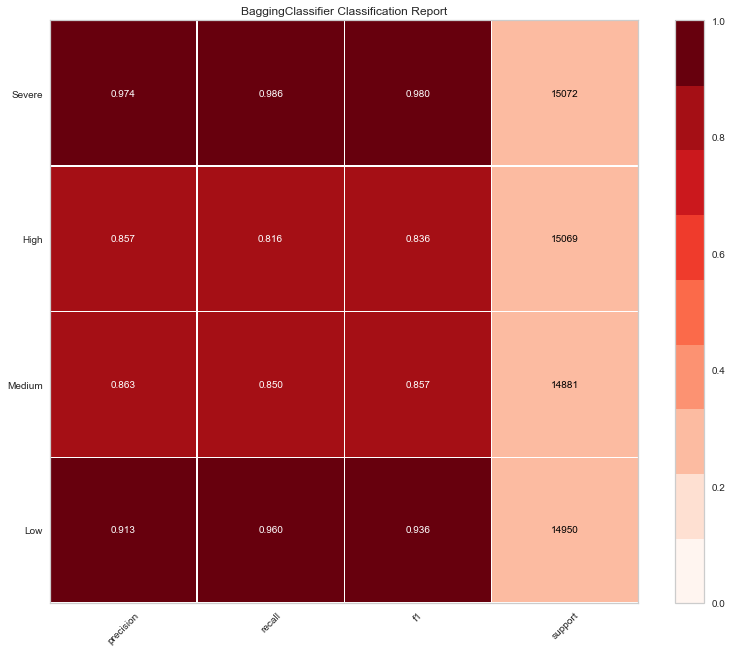

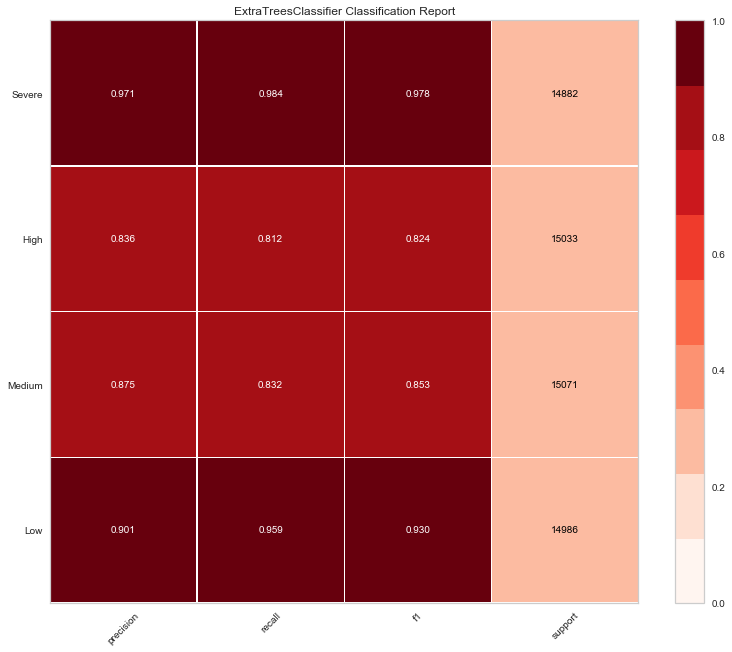

In [17]:
for model in models:
    visualize_model(X, y, model)
    

In [ ]:
def confusion_matrix_report (X, y, estimator, **kwargs):
    
    
    # Processing y.
    y = LabelEncoder().fit_transform(y) # Label-encode targets before modeling
    
   
    #smote models for balance bins for classifier 
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
   
    model = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('estimator', estimator)
      ])
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
    
    # Instantiate the classification model and visualizer
    model.fit(X_train, y_train, **kwargs)  
    
    expected =  y_test
    predicted = model.predict(X_test)
    
    print(confusion_matrix(expected, predicted))
    print(classification_report(expected, predicted))

    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='micro')))

   
    return save_estimator(estimator)

In [ ]:
for model in models:
    confusion_matrix_report(X, y, model)

---
#### ROCAUC For Bagging Classifier 

In [ ]:

# Instantiate the classification model and visualizer
visualizer = ROCAUC(BaggingClassifier(), size=(1080, 720))
                                           
# Create the train and test data
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3)


visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

### ROCAUC Curve for Extra Trees

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ROCAUC(ExtraTreesClassifier(n_estimators=10), classes=classes, size=(1080, 720))
                                           
# Create the train and test data
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3)


visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data


### Examine Class Prediction Error

In [10]:

def class_pred_error (X,y, estimator):


    classes=['Low', 'Medium', 'High', 'Severe']

    
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
   
    model = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('estimator', estimator)
      ])
    
    # Perform 80/20 training/test split
    X_train, X_test, y_train, y_test = tts(
        X, y, test_size=0.20, random_state=42
    )

    # Instantiate the classification model and visualizer
    '''
    visualizer = ClassPredictionError(
    RandomForestClassifier(n_estimators=10), 
    classes=classes, size=(1080, 720)
    )
    '''
    
    visualizer = ClassPredictionError(
        model, 
        classes=classes, size=(1080, 720)
    )

    # Fit the training data to the visualizer
    visualizer.fit(X_train, y_train)

    # Evaluate the model on the test data
    visualizer.score(X_test, y_test)

    # Draw visualization
    visualizer.show()



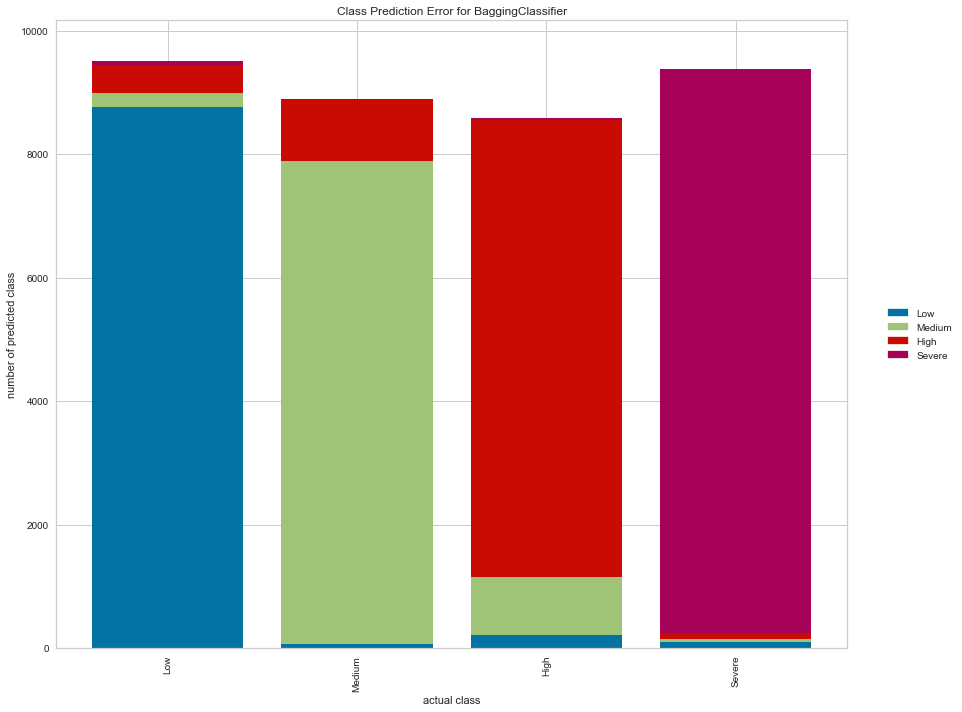

NotFittedError: This ExtraTreesClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

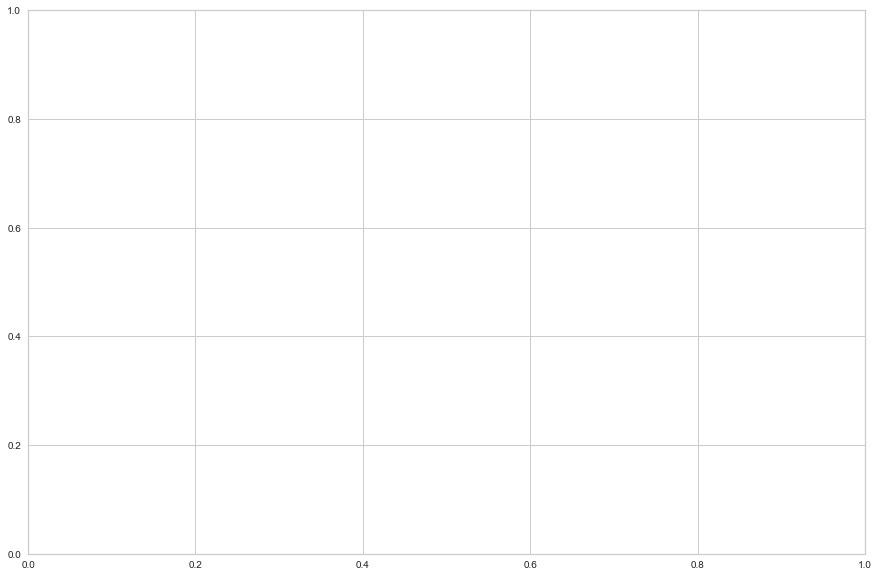

In [11]:
for model in models:
    class_pred_error(X, y, model)